In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("andradaolteanu/gtzan-dataset-music-genre-classification")

print("Path to dataset files:", path)

100%|██████████| 1.21G/1.21G [00:05<00:00, 247MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/andradaolteanu/gtzan-dataset-music-genre-classification/versions/1


In [ ]:
# glob는 파일 경로를 검색하는 데 사용하는 Python 표준 라이브러리

import glob
audio_dir = "/root/.cache/kagglehub/datasets/andradaolteanu/gtzan-dataset-music-genre-classification/versions/1/Data"

# 재귀적으로 모든 .wav 파일 탐색
audio_files = glob.glob(f"{audio_dir}/**/*.wav", recursive=True)
print(f"총 {len(audio_files)}개의 오디오 파일을 발견했습니다.")
# .wav 파일들의 파일 경로 리스트로 반환

총 1000개의 오디오 파일을 발견했습니다.


In [ ]:
!pip install resampy


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 28.9 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import os
import soundfile as sf
import resampy
import matplotlib.pyplot as plt


In [ ]:
# 파일 경로에서 장르 추출 및 데이터프레임 생성
def extract_genre_from_path(path):
    parts = path.split(os.sep)
    for part in parts:
        if part in ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']:
            return part
    return None

# 문제가 있는 파일을 제외하고 데이터프레임 생성
data = pd.DataFrame({
    'path': audio_files,
    'genre': [extract_genre_from_path(path) for path in audio_files]
})

# jazz.00054.wav 파일 제외
data = data[~data['path'].str.contains('jazz.00054.wav')]

print("최종 데이터셋 크기:", len(data))
print("\n장르별 데이터 분포:")
print(data['genre'].value_counts())

최종 데이터셋 크기: 999

장르별 데이터 분포:
genre
blues        100
metal        100
classical    100
country      100
rock         100
hiphop       100
reggae       100
pop          100
disco        100
jazz          99
Name: count, dtype: int64


In [ ]:
import librosa
import librosa.display
import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset
import torchvision.transforms as transforms

def create_melspectrogram(audio_path, sr=22050, n_mels=128, hop_length=512, duration=30):
    """
    오디오 파일을 Mel-spectrogram으로 변환하는 함수

    Parameters:
        audio_path (str): 오디오 파일 경로
        sr (int): 샘플링 레이트
        n_mels (int): Mel 밴드의 수
        hop_length (int): STFT의 hop length
        duration (int): 고정할 오디오 길이(초)


    Returns:
        np.array: Mel-spectrogram 이미지 (3채널)
    """
    # 고정된 길이(30초)만큼 오디오 로드
    y, sr = librosa.load(audio_path, sr=sr, duration=duration)

    # 길이가 30초보다 짧은 경우 패딩
    if len(y) < sr * duration:
        y = np.pad(y, (0, sr * duration - len(y)))

    # Mel-spectrogram 생성
    mel_spect = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels, hop_length=hop_length)

    # Power to dB
    mel_spect_db = librosa.power_to_db(mel_spect, ref=np.max)

    # Normalize
    mel_spect_norm = (mel_spect_db - mel_spect_db.min()) / (mel_spect_db.max() - mel_spect_db.min())

    # 3채널로 변환 (RGB)
    mel_spect_3channel = np.stack([mel_spect_norm] * 3, axis=0)

    return mel_spect_3channel

class GTZANDataset(Dataset):
    """
    GTZAN 데이터셋을 위한 PyTorch Dataset 클래스
    """
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform
        self.genre_to_idx = {genre: idx for idx, genre in enumerate(sorted(df['genre'].unique()))}

    def __len__(self):
        return len(self.df)  # 데이터셋의 총 크기를 반환

    def __getitem__(self, idx):
        audio_path = self.df.iloc[idx]['path']
        genre = self.df.iloc[idx]['genre']

        # Mel-spectrogram 생성
        mel_spect = create_melspectrogram(audio_path)

        # Transform 적용
        if self.transform:
            mel_spect = torch.from_numpy(mel_spect)
            mel_spect = self.transform(mel_spect)

        # 라벨 생성
        label = self.genre_to_idx[genre]

        return mel_spect, label

# 데이터 변환을 위한 transform 정의
def get_transforms(height=224, width=224):
    """
    EfficientNet 입력 크기에 맞는 transform 함수 반환
    """
    transform = transforms.Compose([
        transforms.Resize((height, width)),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # EfficientNet 스타일로 정규화
    ])
    return transform

In [ ]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

# 먼저 학습:검증:테스트 = 70:15:15로 나누기
train_df, temp_df = train_test_split(data, test_size=0.3, random_state=42, stratify=data['genre'])
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df['genre'])

print("학습 데이터 크기:", len(train_df))
print("검증 데이터 크기:", len(val_df))
print("테스트 데이터 크기:", len(test_df))

# transform 생성
transform = get_transforms()

# Dataset 생성
train_dataset = GTZANDataset(train_df, transform=transform)
val_dataset = GTZANDataset(val_df, transform=transform)
test_dataset = GTZANDataset(test_df, transform=transform)

# DataLoader 생성
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# 장르와 인덱스 매핑 확인
genre_to_idx = train_dataset.genre_to_idx
print("\n장르 매핑:")
for genre, idx in genre_to_idx.items():
    print(f"{genre}: {idx}")

학습 데이터 크기: 699
검증 데이터 크기: 150
테스트 데이터 크기: 150

장르 매핑:
blues: 0
classical: 1
country: 2
disco: 3
hiphop: 4
jazz: 5
metal: 6
pop: 7
reggae: 8
rock: 9


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [ ]:
import torch.nn as nn
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights

# EfficientNet-B0 모델 생성
def create_model(num_classes=10):
    # 사전 학습된 가중치로 모델 로드
    model = efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)

    # 모든 레이어의 가중치를 학습 가능하게 설정
    for param in model.parameters():
        param.requires_grad = True
    # 마지막 분류층 수정
    in_features = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(in_features, num_classes)

    return model

# 모델 생성 및 GPU로 이동
model = create_model()
model = model.to(device)

# 파인튜닝을 위한 서로 다른 학습률 설정
# 기존 레이어는 더 작은 학습률, 새로운 분류층은 더 큰 학습률
optimizer = torch.optim.Adam([
    # 기존 레이어
    {'params': [param for name, param in model.named_parameters()
                if 'classifier' not in name], 'lr': 1e-4},
    # 새로운 분류층
    {'params': model.classifier.parameters(), 'lr': 1e-3}
])

# 손실 함수
criterion = nn.CrossEntropyLoss()

# 학습률 스케줄러 (학습률을 동적으로 수정)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=5, verbose=True
)

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1: 100%|██████████| 11/11 [01:11<00:00,  6.54s/it, loss=1.8736, acc=30.90%]



Epoch [1/15]
Train Loss: 2.1181, Train Acc: 30.90%
Val Loss: 2.1578, Val Acc: 28.00%
--------------------------------------------------


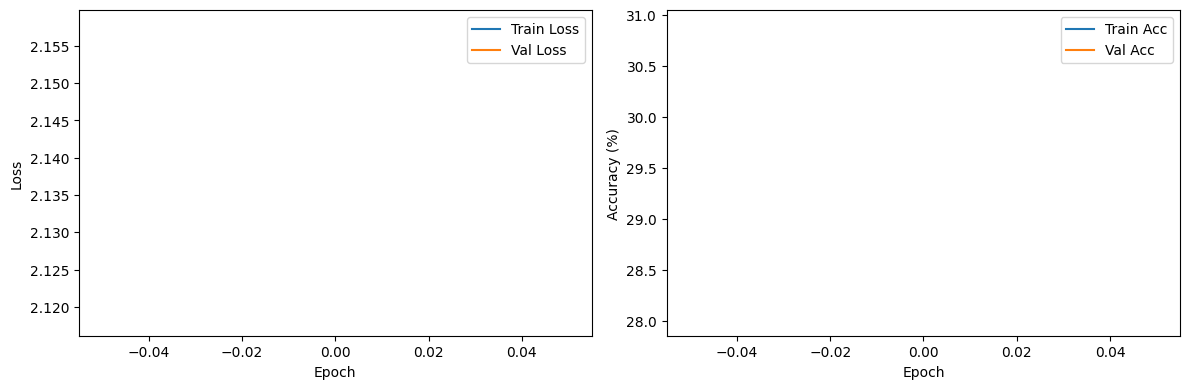

Epoch 2: 100%|██████████| 11/11 [00:50<00:00,  4.61s/it, loss=1.2447, acc=66.95%]



Epoch [2/15]
Train Loss: 1.5134, Train Acc: 66.95%
Val Loss: 1.6773, Val Acc: 48.00%
--------------------------------------------------


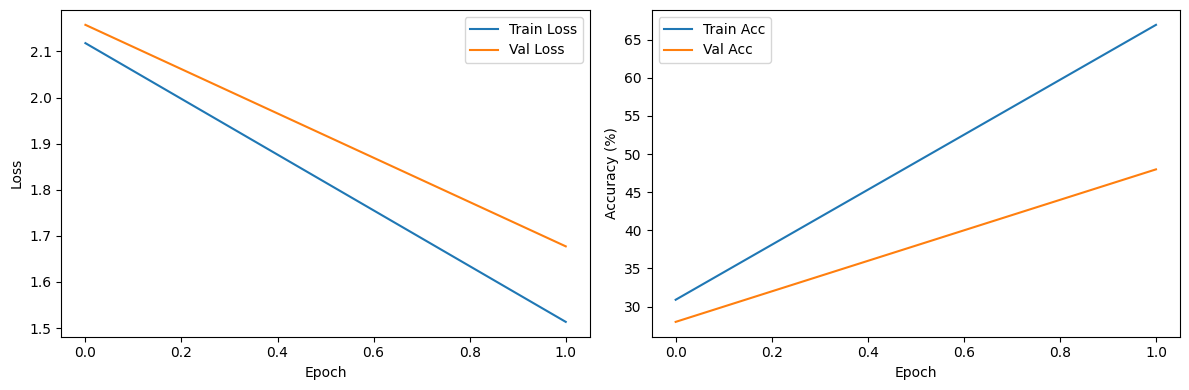

Epoch 3: 100%|██████████| 11/11 [00:58<00:00,  5.33s/it, loss=0.9411, acc=77.25%]



Epoch [3/15]
Train Loss: 1.0317, Train Acc: 77.25%
Val Loss: 1.3315, Val Acc: 56.00%
--------------------------------------------------


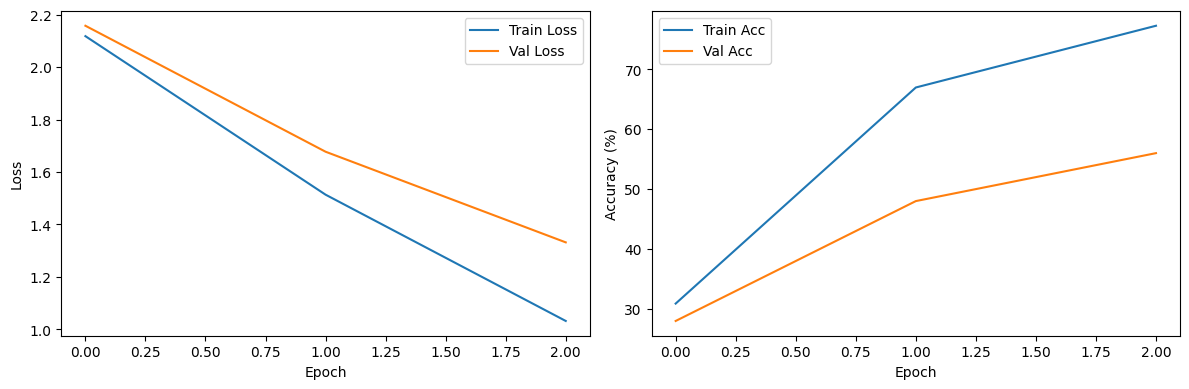

Epoch 4: 100%|██████████| 11/11 [00:53<00:00,  4.83s/it, loss=0.7045, acc=85.69%]



Epoch [4/15]
Train Loss: 0.6932, Train Acc: 85.69%
Val Loss: 1.1116, Val Acc: 62.67%
--------------------------------------------------


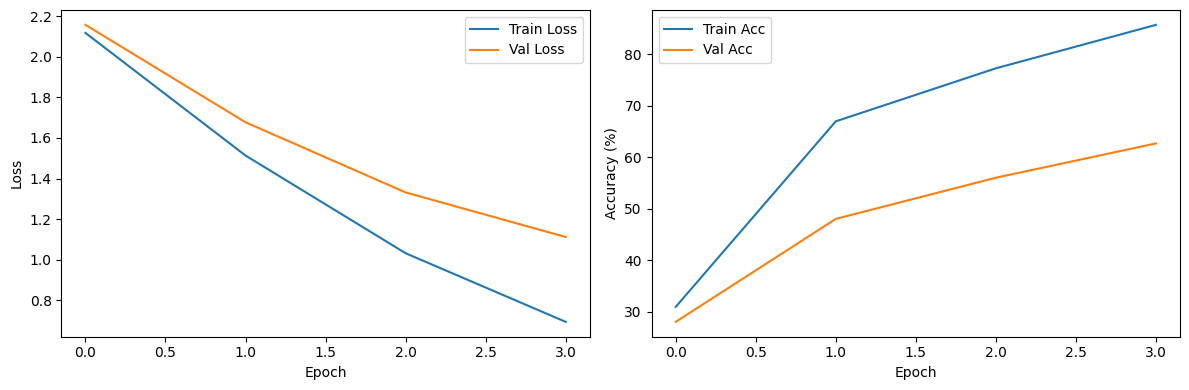

Epoch 5: 100%|██████████| 11/11 [00:54<00:00,  4.92s/it, loss=0.5123, acc=86.98%]



Epoch [5/15]
Train Loss: 0.4975, Train Acc: 86.98%
Val Loss: 1.0162, Val Acc: 63.33%
--------------------------------------------------


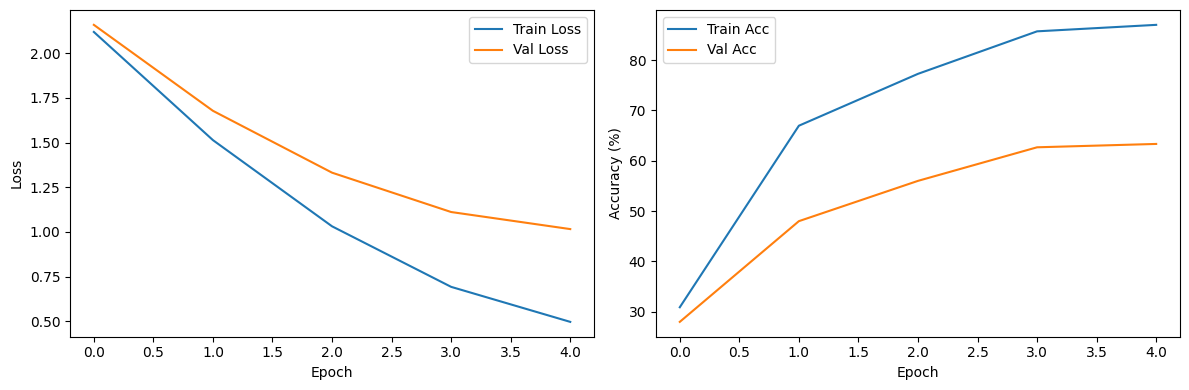

Epoch 6: 100%|██████████| 11/11 [00:52<00:00,  4.81s/it, loss=0.2781, acc=93.42%]



Epoch [6/15]
Train Loss: 0.3059, Train Acc: 93.42%
Val Loss: 0.8889, Val Acc: 69.33%
--------------------------------------------------


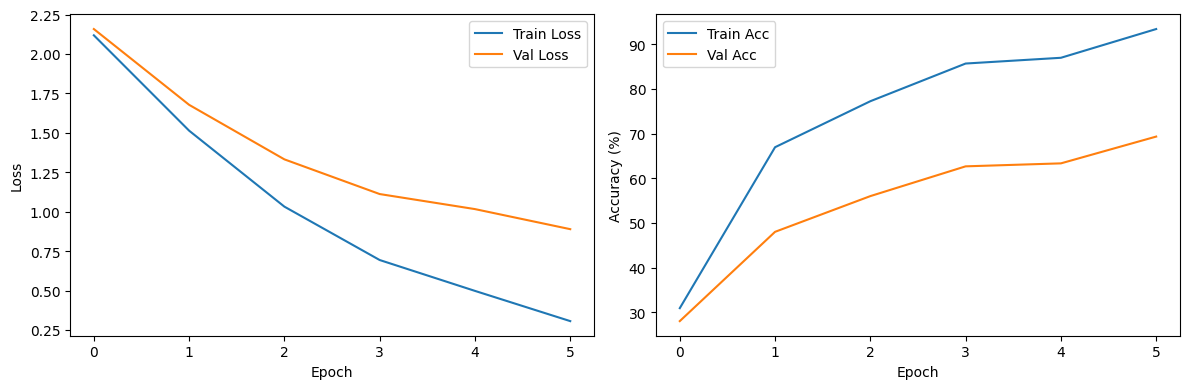

Epoch 7: 100%|██████████| 11/11 [00:59<00:00,  5.42s/it, loss=0.2119, acc=97.57%]



Epoch [7/15]
Train Loss: 0.1962, Train Acc: 97.57%
Val Loss: 0.8443, Val Acc: 70.67%
--------------------------------------------------


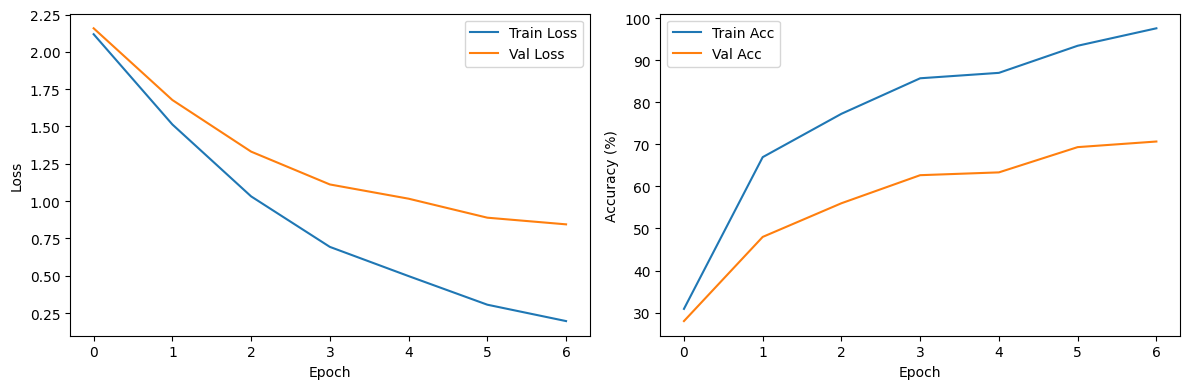

Epoch 8: 100%|██████████| 11/11 [00:51<00:00,  4.64s/it, loss=0.0783, acc=97.57%]



Epoch [8/15]
Train Loss: 0.1280, Train Acc: 97.57%
Val Loss: 0.8132, Val Acc: 72.00%
--------------------------------------------------


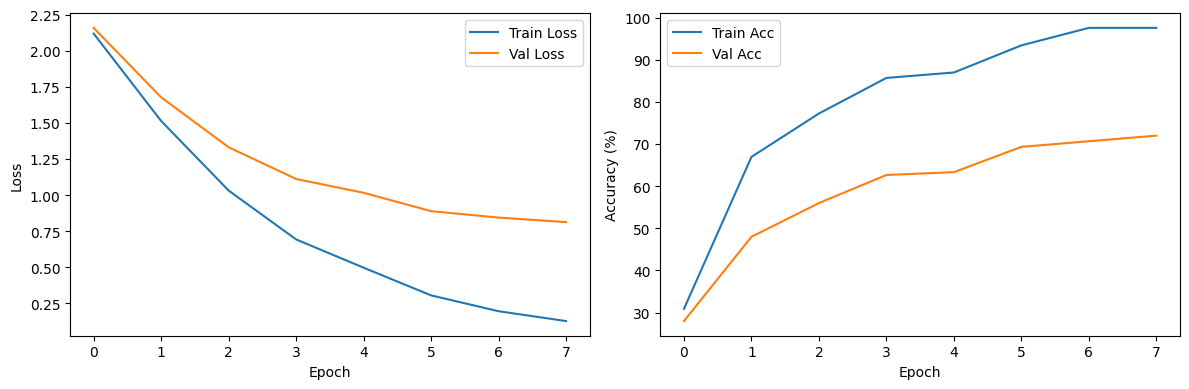

Epoch 9: 100%|██████████| 11/11 [00:56<00:00,  5.14s/it, loss=0.1757, acc=97.28%]



Epoch [9/15]
Train Loss: 0.1210, Train Acc: 97.28%
Val Loss: 0.7672, Val Acc: 72.67%
--------------------------------------------------


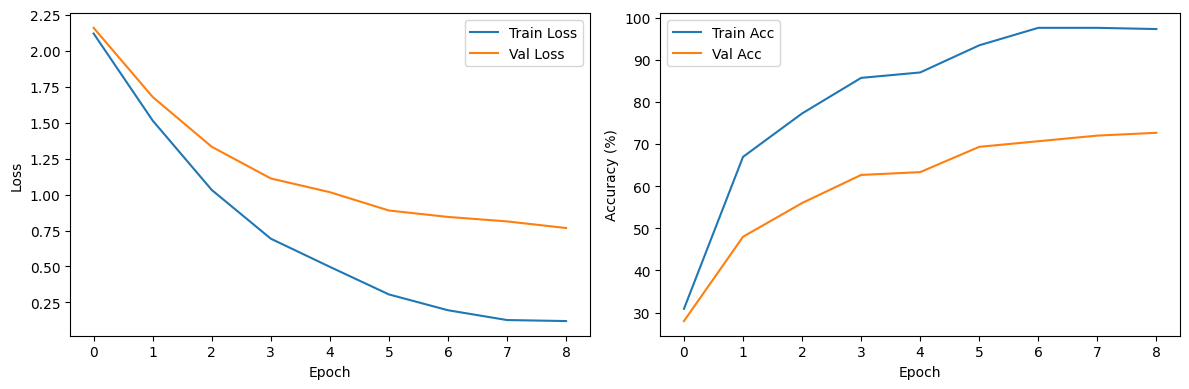

Epoch 10: 100%|██████████| 11/11 [00:54<00:00,  4.95s/it, loss=0.0752, acc=99.71%]



Epoch [10/15]
Train Loss: 0.0680, Train Acc: 99.71%
Val Loss: 0.7800, Val Acc: 73.33%
--------------------------------------------------


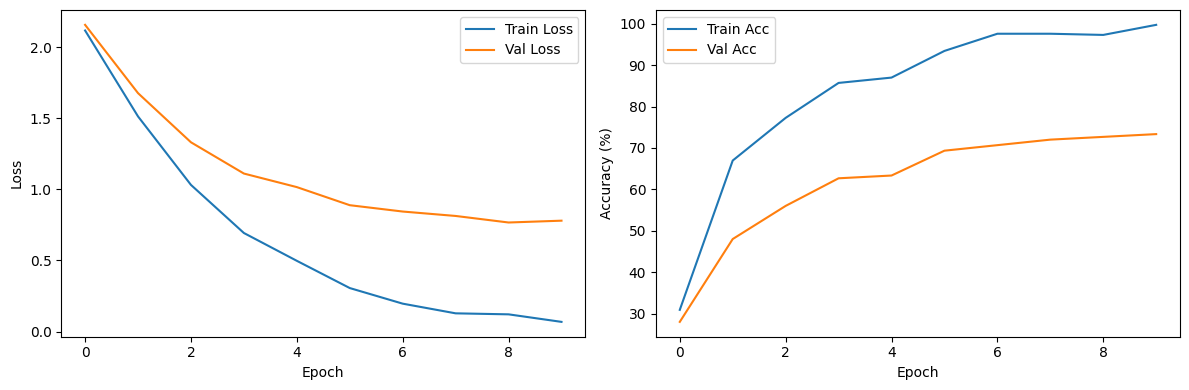

Epoch 11: 100%|██████████| 11/11 [01:01<00:00,  5.62s/it, loss=0.0783, acc=99.57%]



Epoch [11/15]
Train Loss: 0.0589, Train Acc: 99.57%
Val Loss: 0.7907, Val Acc: 75.33%
--------------------------------------------------


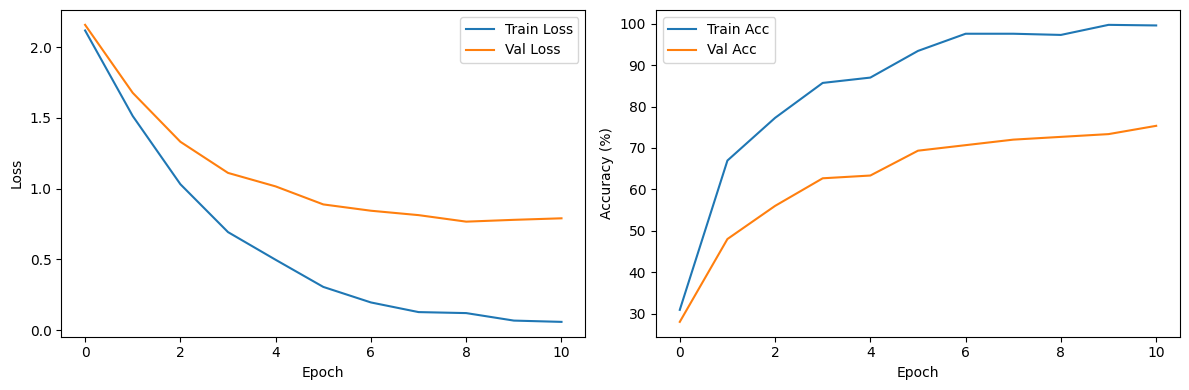

Epoch 12: 100%|██████████| 11/11 [00:55<00:00,  5.01s/it, loss=0.0394, acc=100.00%]



Epoch [12/15]
Train Loss: 0.0350, Train Acc: 100.00%
Val Loss: 0.7915, Val Acc: 74.00%
--------------------------------------------------


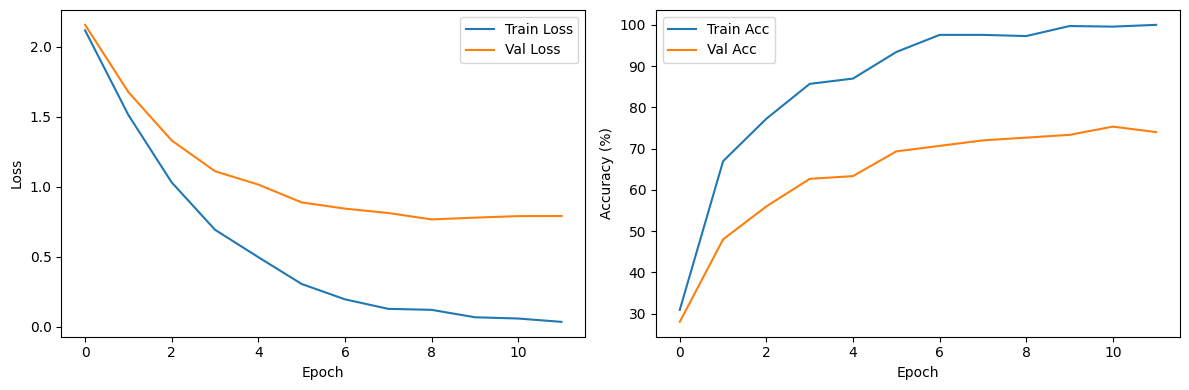

Epoch 13: 100%|██████████| 11/11 [00:51<00:00,  4.71s/it, loss=0.0573, acc=99.43%]



Epoch [13/15]
Train Loss: 0.0350, Train Acc: 99.43%
Val Loss: 0.7909, Val Acc: 74.00%
--------------------------------------------------


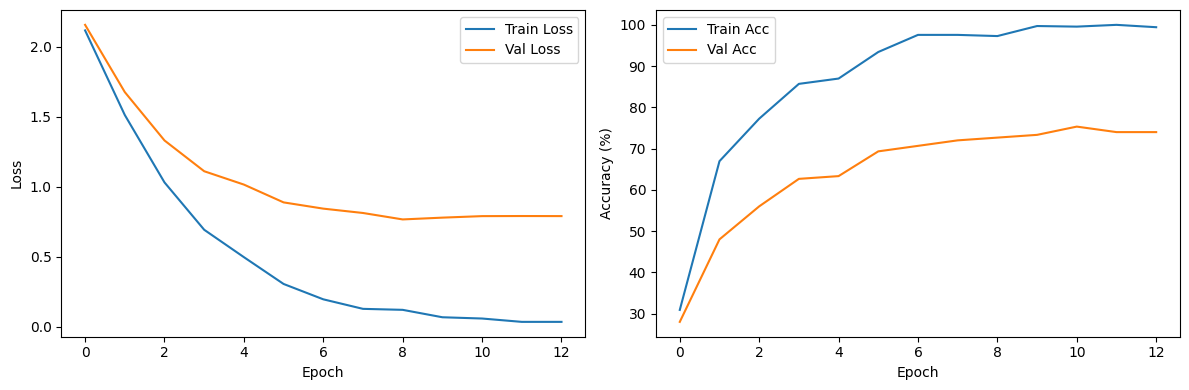

Epoch 14: 100%|██████████| 11/11 [00:54<00:00,  4.95s/it, loss=0.0199, acc=99.14%]



Epoch [14/15]
Train Loss: 0.0427, Train Acc: 99.14%
Val Loss: 0.7842, Val Acc: 74.67%
--------------------------------------------------


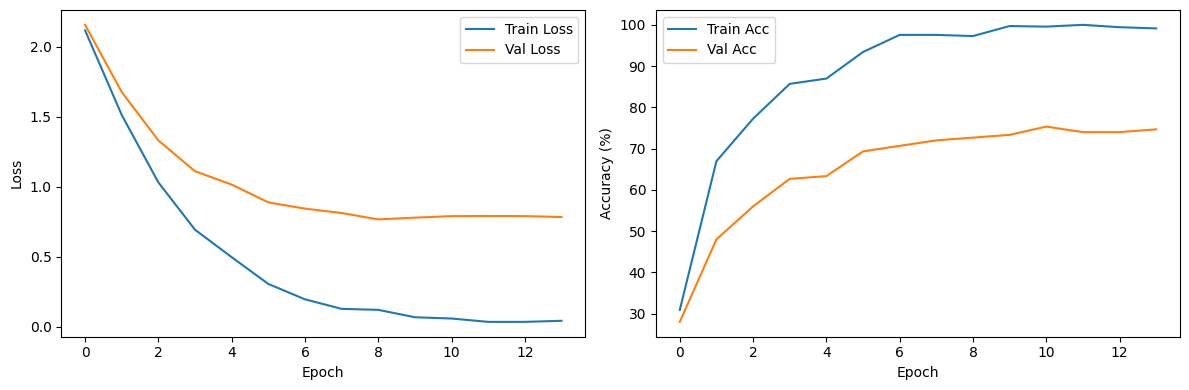

Epoch 15: 100%|██████████| 11/11 [00:52<00:00,  4.80s/it, loss=0.0183, acc=99.43%]



Epoch [15/15]
Train Loss: 0.0350, Train Acc: 99.43%
Val Loss: 0.7668, Val Acc: 74.00%
--------------------------------------------------


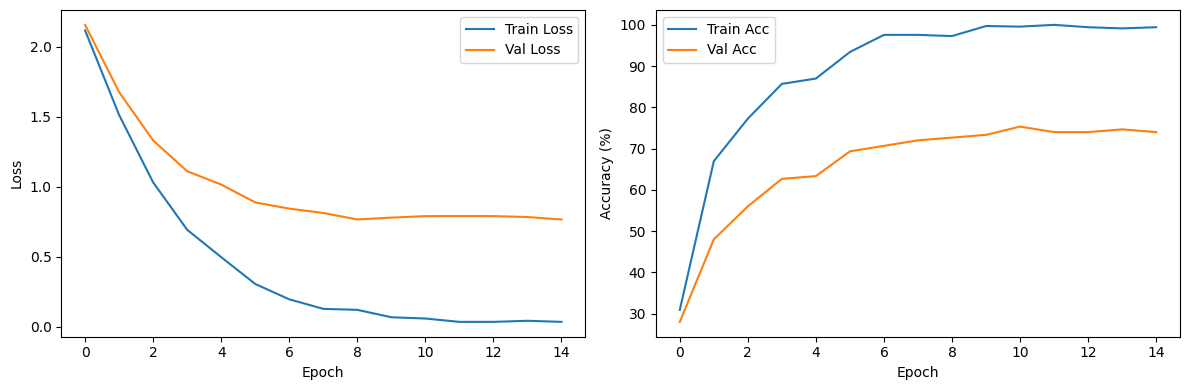

In [ ]:
from tqdm import tqdm
import matplotlib.pyplot as plt

def train_one_epoch(model, train_loader, criterion, optimizer, device, epoch):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    # tqdm으로 진행바 표시
    pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}')
    for inputs, labels in pbar:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        # 현재 배치의 loss와 accuracy를 진행바에 표시
        batch_loss = loss.item()
        batch_acc = 100. * correct / total
        pbar.set_postfix({'loss': f'{batch_loss:.4f}',
                         'acc': f'{batch_acc:.2f}%'})

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc

def validate(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    val_loss = running_loss / len(val_loader)
    val_acc = 100. * correct / total
    return val_loss, val_acc

# 학습 결과를 저장할 리스트
train_losses = []
train_accs = []
val_losses = []
val_accs = []

num_epochs = 15
best_val_acc = 0

for epoch in range(num_epochs):
    # 학습
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device, epoch)
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # 검증
    val_loss, val_acc = validate(model, val_loader, criterion, device)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    # 학습률 조정
    scheduler.step(val_loss)

    # 베스트 모델 저장
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_model.pth')

    print(f'\nEpoch [{epoch+1}/{num_epochs}]')
    print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
    print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
    print('-' * 50)

    # 매 에폭마다 그래프 그리기
    plt.figure(figsize=(12, 4))

    # Loss 그래프
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy 그래프
    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Train Acc')
    plt.plot(val_accs, label='Val Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.tight_layout()
    plt.show()

#테스트 데이터에 대한 평가 및 혼동행렬 분석

<ipython-input-17-db49fa2e58b2>:48: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


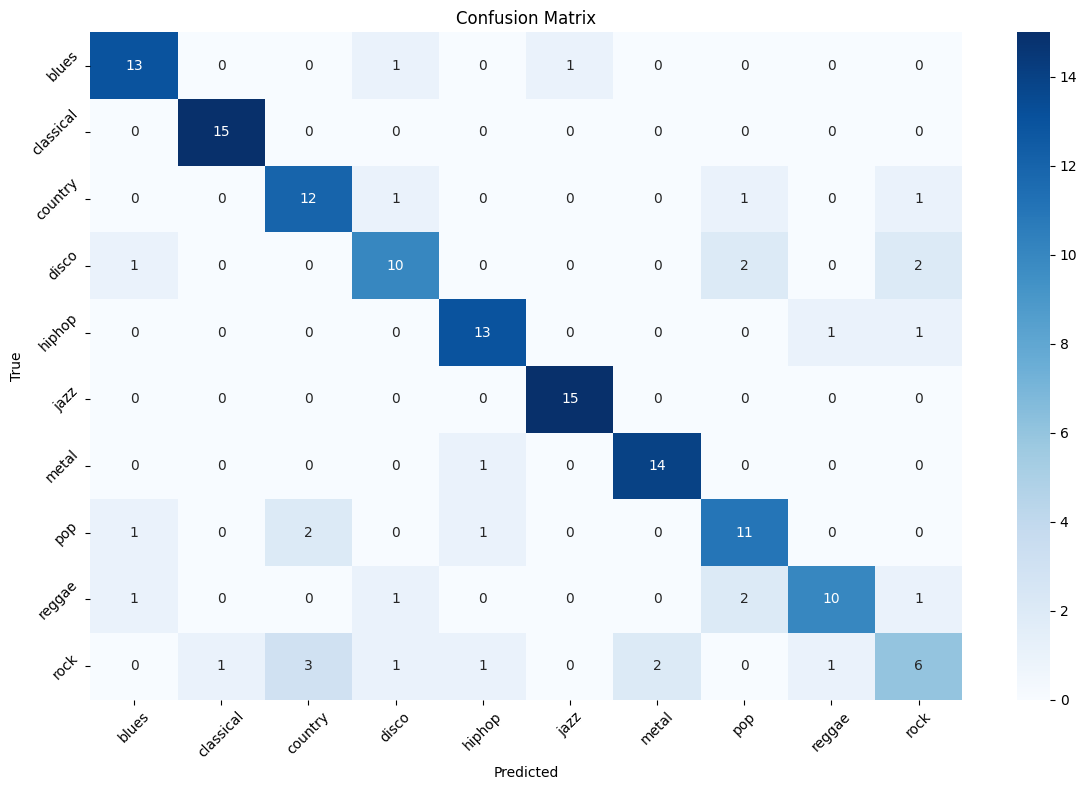


Classification Report:
              precision    recall  f1-score   support

       blues       0.81      0.87      0.84        15
   classical       0.94      1.00      0.97        15
     country       0.71      0.80      0.75        15
       disco       0.71      0.67      0.69        15
      hiphop       0.81      0.87      0.84        15
        jazz       0.94      1.00      0.97        15
       metal       0.88      0.93      0.90        15
         pop       0.69      0.73      0.71        15
      reggae       0.83      0.67      0.74        15
        rock       0.55      0.40      0.46        15

    accuracy                           0.79       150
   macro avg       0.79      0.79      0.79       150
weighted avg       0.79      0.79      0.79       150


Overall Test Accuracy: 79.33%


In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

def evaluate_model(model, test_loader, device):
    model.eval()
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)

            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # 혼동 행렬 계산
    conf_matrix = confusion_matrix(all_labels, all_predictions)

    # 장르 이름 가져오기 (인덱스를 장르 이름으로 매핑)
    idx_to_genre = {v: k for k, v in genre_to_idx.items()}
    genre_names = [idx_to_genre[i] for i in range(len(genre_to_idx))]

    # 혼동 행렬 시각화
    plt.figure(figsize=(12, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=genre_names, yticklabels=genre_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # 분류 보고서 출력
    print("\nClassification Report:")
    print(classification_report(all_labels, all_predictions,
                              target_names=genre_names))

    # 전체 정확도 계산
    accuracy = (np.array(all_predictions) == np.array(all_labels)).mean()
    print(f"\nOverall Test Accuracy: {accuracy*100:.2f}%")

# 저장된 최상의 모델 불러오기
model.load_state_dict(torch.load('best_model.pth'))

# 평가 실행
evaluate_model(model, test_loader, device)